<a href="https://colab.research.google.com/github/rashidmeras/EVA_PHASE1/blob/master/EVA_S11_Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA Session11 Assignment 11: 

Objective:




In [1]:
import time
import math
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(900) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, Convolution2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import backend as K

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

import cv2
from keras.preprocessing import image
from google.colab.patches import cv2_imshow

import matplotlib.gridspec as gridspec

Using TensorFlow backend.


In [0]:
def get_cifar10_data():
    from keras.datasets import cifar10
    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
    num_train, img_channels, img_rows, img_cols =  train_features.shape
    num_test, _, _, _ =  test_features.shape
    num_classes = len(np.unique(train_labels))

    # Flatten 32x32x3 images to a 1024*3 vector for each image.
    train_features = train_features.reshape(train_features.shape[0], 32, 32, 3)
    test_features = test_features.reshape(test_features.shape[0], 32, 32, 3)

    train_features = train_features.astype('float32')/255
    test_features = test_features.astype('float32')/255

    # convert class labels to binary class labels
    train_labels = np_utils.to_categorical(train_labels, num_classes)
    test_labels = np_utils.to_categorical(test_labels, num_classes)
    return (train_features, train_labels), (test_features, test_labels)

def get_cifar10_labels():
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
    return class_names

def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()
    
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()    
        
# Cut-out
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True):
  
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img

    return eraser
    
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
  
# Min-Max scale  
def min_max_scale(X):
    return (X - np.min(X))/(np.max(X)-np.min(X))  

170500096/170498071 [==============================] - 13s 0us/step


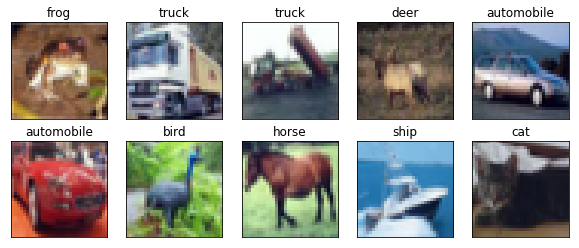

In [3]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

#  load cifar10 data  
(train_features, train_labels), (test_features, test_labels) = get_cifar10_data()

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# prepare an iterators to scale images
train_iterator = datagen.flow(train_features, train_labels, batch_size, shuffle=False)

# calculate mean on training dataset
xyz = datagen.fit(train_features)

train_features, train_labels = train_iterator.next()

train_features = min_max_scale(train_features)

show_examples(train_features[0:10], train_labels[0:10], classes=get_cifar10_labels())

In [0]:
# Define the model
def build_model(summary=False):

    model = Sequential()
    
    model.add(Conv2D(32,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer1',input_shape=(32, 32, 3))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, name='Layer3'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False, name='Layer4'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(16,  kernel_size=(1, 1), use_bias=False, name='Layer5'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    #Layer: Max-Pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer6'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, name='Layer7'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False, name='Layer8'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(16,  kernel_size=(1, 1), use_bias=False, name='Layer9'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    #Layer: Max-Pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer10'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64,  kernel_size=(3, 3), use_bias=False, padding='same', name='Layer11'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, kernel_size=(3, 3), use_bias=False, name='Layer12'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(10, kernel_size=(3, 3), use_bias=False, name='Layer13'))
    
    #Layer: Flatten & activation
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
  
    model.compile(optimizer= sgd,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])    
    
    #Print model summary
    if (summary == True):
        model.summary()
        i=0
        for layer in model.layers[0:]:
            if "Layer" in layer.name:
                print ("Layer No.:", i, " Name:", layer.name)
                i+=1        
    
    return model

In [0]:
def train_network(model, epochs=10, verbose=2, with_cutout=False):
  
    save_mcp = ModelCheckpoint('best_new_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    cutout_fn = get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True)

    # Train the model
    start = time.time() 
        
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 preprocessing_function=cutout_fn if with_cutout else None)
    
    datagen_validation = ImageDataGenerator(featurewise_center=True,
                                            featurewise_std_normalization=True)    

    train_iterator      = datagen.flow(train_features, train_labels, batch_size=batch_size, shuffle=True)
    validation_iterator = datagen_validation.flow(test_features, test_labels, batch_size=batch_size, shuffle=True)
  
    train_history = model.fit_generator(train_iterator,
                                        steps_per_epoch  = len(train_iterator), 
                                        validation_data  = validation_iterator, 
                                        validation_steps = len(validation_iterator),
                                        epochs           = epochs, 
                                        verbose          = verbose,
                                        callbacks        = [save_mcp, LearningRateScheduler(step_decay, verbose=1)])    
  
    end = time.time()
    print ("Model took %0.2f seconds to train \n"%(end - start))

    # plot model history
    plot_model_history(train_history)

    return train_history  

In [6]:
# model = build_model(summary=True)
model = build_model()

W0717 17:57:13.547342 139807616468864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 17:57:13.585201 139807616468864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 17:57:13.592190 139807616468864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 17:57:13.628501 139807616468864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0717 17:57:13.629656 1398076164

Epoch 1/25


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
1/1 [==============================] - 6s 6s/step - loss: 0.3426 - acc: 0.9000 - val_loss: 0.3294 - val_acc: 0.9000

Epoch 00001: val_acc improved from -inf to 0.90000, saving model to best_new_model.h5
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
1/1 [==============================] - 1s 1s/step - loss: 0.3359 - acc: 0.8992 - val_loss: 0.3283 - val_acc: 0.9000

Epoch 00002: val_acc did not improve from 0.90000
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
1/1 [==============================] - 1s 1s/step - loss: 0.3236 - acc: 0.9008 - val_loss: 0.3294 - val_acc: 0.9000

Epoch 00003: val_acc did not improve from 0.90000
Epoch 4/25

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
1/1 [==============================] - 1s 1s/step - loss: 0.3254 - acc: 0.9000 - val_loss: 0.3316 - val_acc: 0.9000

Epoch 00004: val_acc did not improve from 0.90000

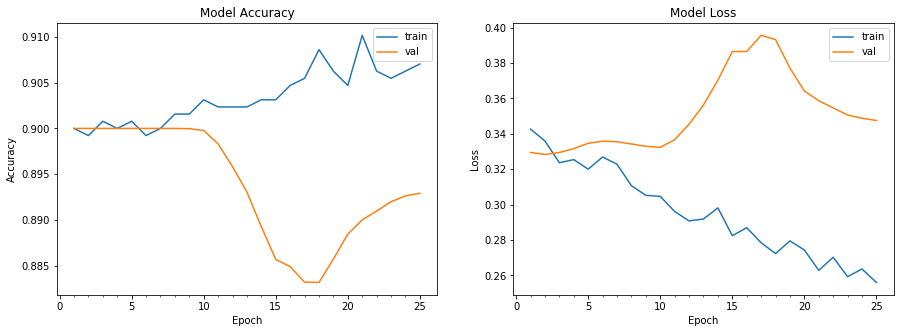

In [7]:
train_history = train_network(model, epochs=25, verbose=1, with_cutout=True)

In [0]:
def process_with_gradcam(model, layer, img_t, class_idx, preprocess_func=None, display=True):

    x = np.expand_dims(image.img_to_array(img_t), axis=0)        
    img_t = np.copy(img_t)        
    class_idx = np.argmax(class_idx, axis=0) if type(class_idx)==list or type(class_idx)==np.ndarray else class_idx
    
    if preprocess_func is not None:
       x = preprocess_func(x)    
        
    preds = model.predict(x)  
    preds = np.argmax(preds, axis=1)[0]
    
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer)      
    layer_out_channels = last_conv_layer.output_shape[-1]    
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
  
    for i in range(64):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]    
        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
  
    heatmap = cv2.resize(heatmap, (img_t.shape[1], img_t.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
    heatmap = heatmap/255
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if heatmap[i][j][1]<=0.01 and heatmap[i][j][2]<=0.01:
                heatmap[i][j] = 0
        
    img_t = (img_t - np.min(img_t))/(np.max(img_t)-np.min(img_t))
    superimposed_img = 0.65*(img_t) + 0.35*heatmap
  
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if np.sum(heatmap[i][j])==0:
                superimposed_img[i][j]=img_t[i][j]
  
    if display:
        plt.imshow(img_t)
        plt.axis("off")
        plt.show()
        plt.imshow(heatmap)
        plt.axis("off")
        plt.show()
        plt.imshow(superimposed_img)
        plt.axis("off")
        plt.show()
        
    return img_t,heatmap,superimposed_img,preds
    
def show_examples_with_gradcam(model,layer,images,labels,classes=None,preprocess_func=None,image_size_multiplier=3):
# def show_examples_with_gradcam(model, layer, images, labels, classes=None, preprocess_func=None, preprocess_img=None,
#                                image_size_multiplier=3,
#                                show_actual=True, show_heatmap=False, show_superimposed=True):  
    columns = 5
    rows = int(np.ceil(len(images) / columns))
    labels = np.argmax(labels, axis=1) if type(labels[0])==list or type(labels[0])==np.ndarray else labels
    fig_height = rows * image_size_multiplier * 3
    fig_width = columns * image_size_multiplier
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
    for i in range(rows*columns):
        if i>=len(images):
            break
        x = images[i]
        y = labels[i]

        img,heatmap,superimposed_img,prediction = process_with_gradcam(model,layer,x,y,preprocess_func=preprocess_func,display=False)
        inner = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[i], wspace=0.0, hspace=0.15)
                    
        imgs = [img,heatmap,superimposed_img]
        label = classes[y] if classes is not None else ""
        label = label.split(' ', 1)[0]
        prediction = classes[prediction]
        titles = [("Actual:"+label+" Pred:"+prediction).replace(' ', '\n'),"HeatMap","SuperImposed Image"]
        for j in range(3):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(imgs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(titles[j])
            fig.add_subplot(ax)
  
    fig.show()  
    
def find_misclassified(X, y_true, y_pred):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    misclassified = y_true != y_pred
    X = X[misclassified]
    y_true = y_true[misclassified]
    y_pred = y_pred[misclassified]
    return X, y_true, y_pred
  
def show_misclassified_with_gradcam(model, layer, iterator, classes=None, preprocess_func=None, preprocess_img=None,
                                    image_size_multiplier=3, examples=25,
                                    show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(examples / columns))
    images = []
    labels = []
    predictions = []
    while len(images) < examples:
        batchX, batchY = iterator.next()
        preds = model.predict(batchX)
        X, y_true, y_pred = find_misclassified(batchX, batchY, preds)
        images.extend(X)
        labels.extend(y_true)
        predictions.extend(y_pred)

    images = images[:examples]
    labels = labels[:examples]
    predictions = predictions[:examples]

#     show_examples_with_gradcam(model, layer, images, labels, classes=classes, preprocess_func=preprocess_func,
#                                preprocess_img=preprocess_img, image_size_multiplier=image_size_multiplier)
    
    show_examples_with_gradcam(model,layer,images,labels,classes=classes,preprocess_func=preprocess_func,
                               image_size_multiplier=image_size_multiplier)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6

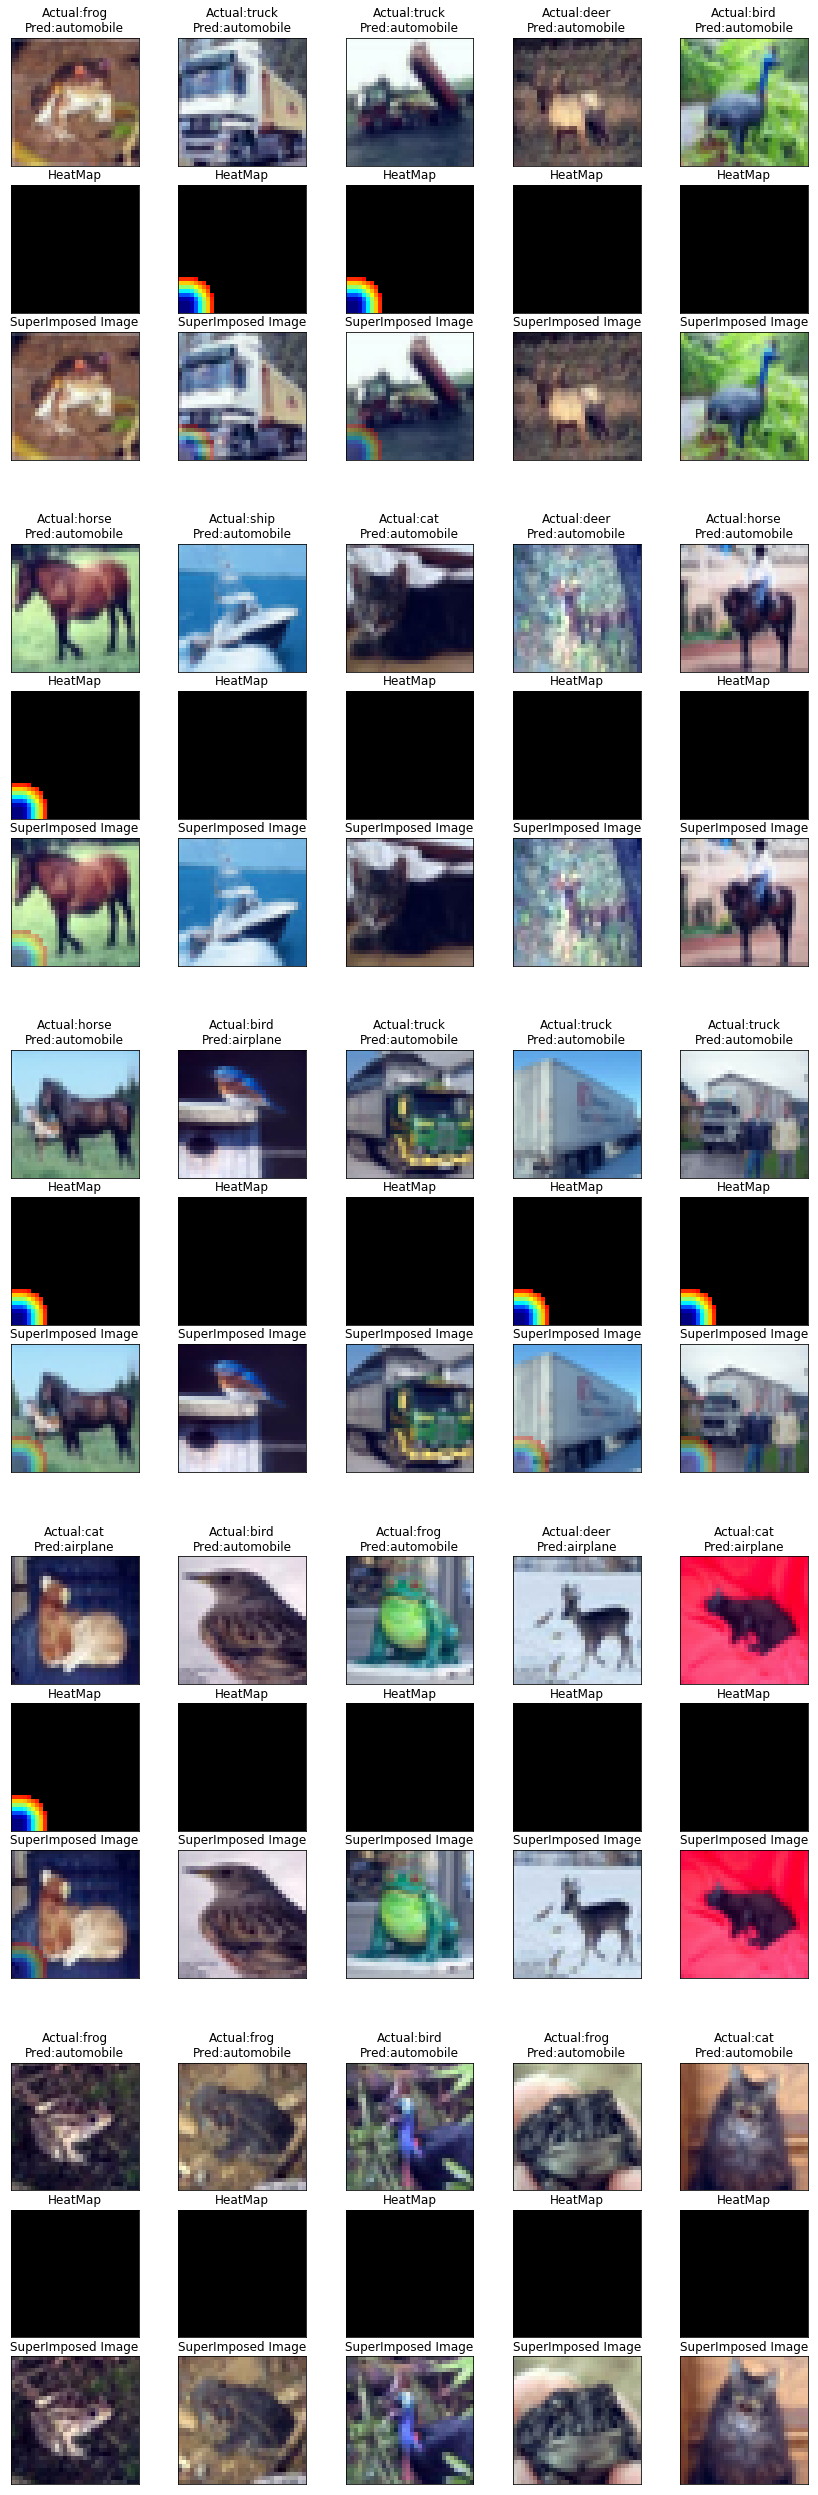

In [16]:
train_iterator      = datagen.flow(train_features, train_labels, batch_size=batch_size, shuffle=False)
show_misclassified_with_gradcam(model, layer="Layer10", iterator=train_iterator, classes=get_cifar10_labels())

## Summary:

A trained network is successfully integrated with GradCAM and 4 images were visualized. The same network was retrained by adding a Data Augmantation method known as CutOff and the same 4 images were visualized.

Thank you!

